# WEEK 9 - gradient boost, learning rate, number of estimators, tree depth, and regularization 


In [ ]:
# !pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import networkx as nx

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Dataset 1
df = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

# Dataset 2
df_pima = pd.read_csv("pima_indian_diabetes_dataset.csv") 

# Dataset 1

Gradient Boosting is faster than KNN, more powerful than logistic regression, and handles nonlinear relationships without needing feature scaling because it uses decicision trees. 

In [6]:
# --- Gradient Boosting Classification - Dataset 1 --- set parameters

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np

# --- 1. Prepare data ---
X = df.drop(columns=['Diabetes_012'])
y = df['Diabetes_012']

# --- 2. Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3. Define model ---
gb = GradientBoostingClassifier(
    n_estimators=150,        # number of boosting stages
    learning_rate=0.1,       # step size
    max_depth=3,             # depth of each tree
    random_state=42
)

# --- 4. Cross-validation ---
cv_scores = cross_val_score(gb, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- 5. Fit and evaluate ---
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# Handle multiclass AUC
if len(np.unique(y)) > 2:
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
else:
    auc = roc_auc_score(y_test, y_prob[:, 1])

print(f"AUC: {auc:.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Cross-Validation Accuracy: 0.850 ± 0.001
Test Accuracy: 0.849
AUC: 0.789

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.55      0.19      0.28      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736



unbalanced had 0 f score for the prediabetes group, so I decided to balance the groups.

In [8]:
# --- Gradient Boosting - Balanced, 10,000 sample set from Dataset 1 ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# --- 1. Create balanced 10,000-sample subset ---
# Sample ~3333 rows per class (replace=True allows oversampling smaller classes)
df_small = (
    df.groupby('Diabetes_012', group_keys=False)
      .apply(lambda x: x.sample(n=3333, replace=True, random_state=42))
)

print(df_small['Diabetes_012'].value_counts())

# --- 2. Prepare data ---
X = df_small.drop(columns=['Diabetes_012'])
y = df_small['Diabetes_012']

# --- 3. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 4. Define Gradient Boosting model ---
gb = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,              
    random_state=42
)

# --- 5. Cross-validation (3-fold for speed) ---
cv_scores = cross_val_score(gb, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- 6. Fit and evaluate on test set ---
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)

# --- 7. Evaluate metrics ---
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# Multiclass AUC
auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"AUC: {auc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))


/tmp/ipykernel_8946/3128545487.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=3333, replace=True, random_state=42))


Diabetes_012
0.0    3333
1.0    3333
2.0    3333
Name: count, dtype: int64
Cross-Validation Accuracy: 0.524 ± 0.002
Test Accuracy: 0.530
AUC: 0.720

Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.63      0.63       666
         1.0       0.44      0.37      0.40       667
         2.0       0.51      0.59      0.55       667

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000



    subsample=0.8, parameter adds randomness → less overfitting


The F1 score improved for prediabetes but decreased for no and yes diabetes. Further parameter tuning is necessary. 

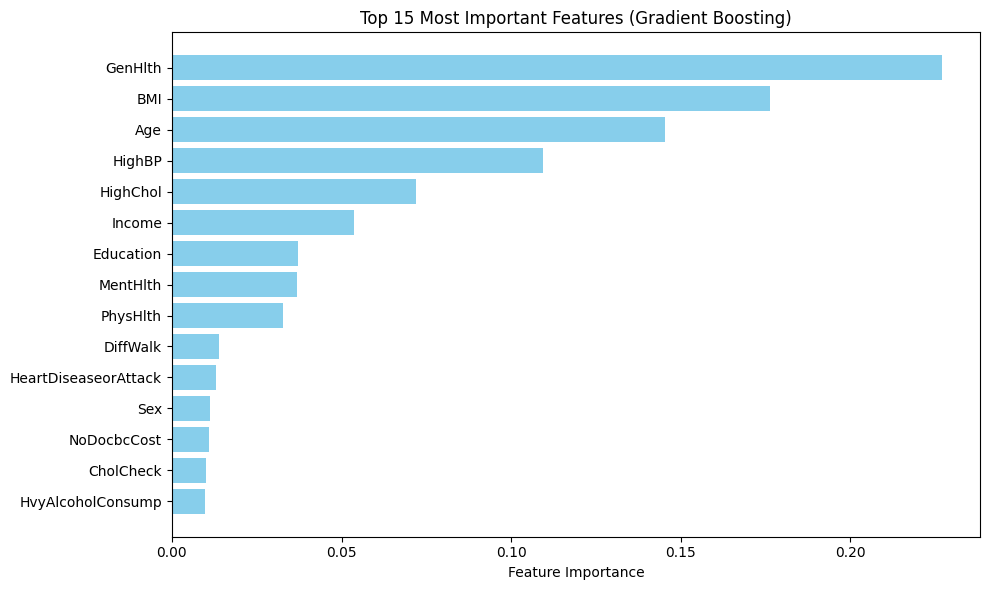

In [ ]:
# Feature Importance Visualization ---
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:15][::-1], 
         feature_importances['Importance'][:15][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (Gradient Boosting)')
plt.tight_layout()
plt.show()

In [13]:
# --- Gradient Boosting Grid Search (Dataset 1) ---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report
)

# --- 1. Create 10,000-sample balanced subset ---
df_small = (
    df.groupby('Diabetes_012', group_keys=False)
      .apply(lambda x: x.sample(n=3333, replace=True, random_state=42))
      .sample(10000, replace=True, random_state=42)
)

X = df_small.drop(columns=['Diabetes_012'])
y = df_small['Diabetes_012']

# --- 2. Scale numeric features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# --- 4. Define model and parameter grid ---
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

# --- 5. Grid Search with F1 scoring ---
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# --- 6. Evaluate best model ---
best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test)
y_prob = best_gb.predict_proba(X_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV F1-macro: {grid_search.best_score_:.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Test F1 (macro): {f1_score(y_test, y_pred, average='macro'):.3f}")
print(f"Recall (macro): {recall_score(y_test, y_pred, average='macro'):.3f}")
print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro'):.3f}")

# --- 7. Compute multi-class AUC ---
auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print(f"AUC (macro): {auc:.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/tmp/ipykernel_8946/1172092501.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=3333, replace=True, random_state=42))


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV F1-macro: 0.673
Test Accuracy: 0.703
Test F1 (macro): 0.703
Recall (macro): 0.703
Precision (macro): 0.704
AUC (macro): 0.863

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73       674
         1.0       0.68      0.67      0.68       672
         2.0       0.68      0.72      0.70       654

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



F1 scores improved drastically after balancing the classes and running grid search. 

Increasing the number of estimators can bring higher accruacy but is slower and more prone to overfitting if there are too many. The learning rate is how much each tree contributes to the final prediction. A smaller rate is slower but more stable while a larger rate is faster but at risk of overfitting. The max depth determines how much each individual tree can grow. Deeper trees capture more complexity but overfit easily while shallow trees generalize better but might underfit.

<Axes: >

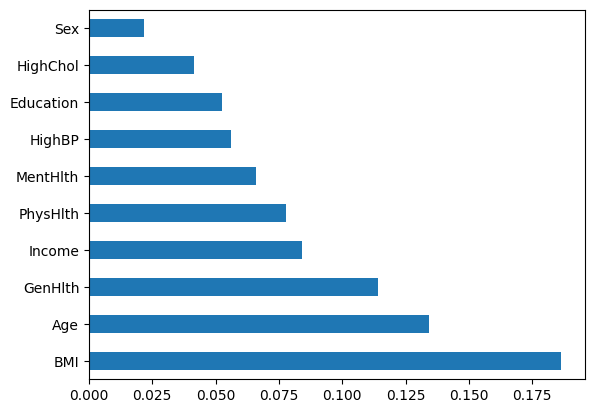

In [16]:
#feature importance check

importances = pd.Series(best_gb.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')

# Dataset 2 

In [10]:
# --- Gradient Boosting Classification - Dataset 2 ---

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import numpy as np

# --- 1. Prepare data ---
X = df_pima.drop(columns=['Outcome'])
y = df_pima['Outcome']

# --- 2. Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3. Define model ---
gb = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# --- 4. Cross-validation ---
cv_scores = cross_val_score(gb, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- 5. Fit and evaluate ---
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"AUC: {roc_auc_score(y_test, y_prob[:, 1]):.3f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Cross-Validation Accuracy: 0.749 ± 0.049
Test Accuracy: 0.760
AUC: 0.831

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       100
           1       0.67      0.63      0.65        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154



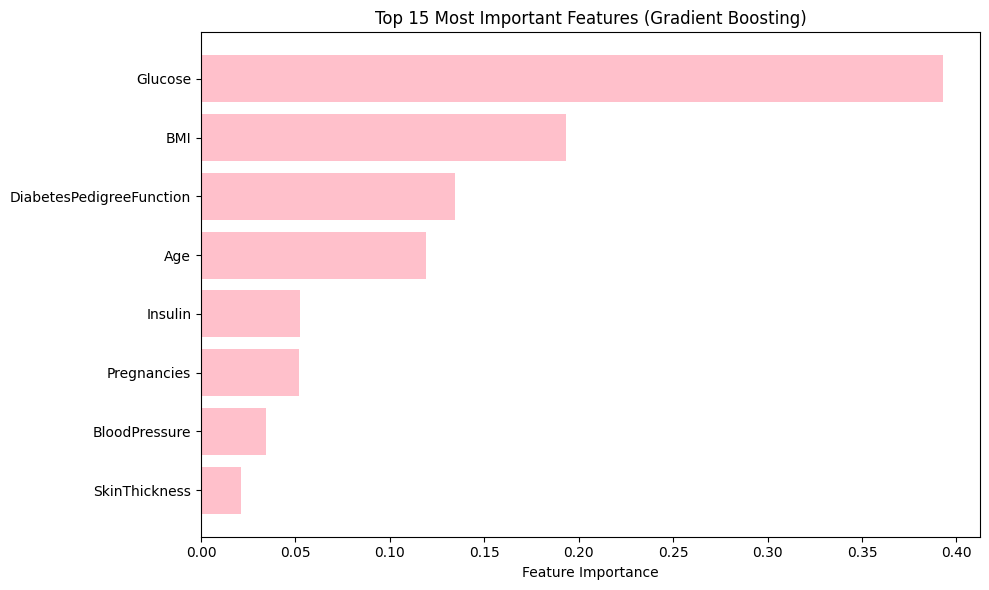

In [11]:
# Feature Importance Visualization ---
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:15][::-1], 
         feature_importances['Importance'][:15][::-1], color='pink')
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (Gradient Boosting)')
plt.tight_layout()
plt.show()

Did not use balanced classes but the scores are decent. There is room for more parameter tuning. 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
Best CV AUC: 0.835
Test Accuracy: 0.747
Test AUC: 0.821

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       100
           1       0.67      0.56      0.61        54

    accuracy                           0.75       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.74      0.75      0.74       154



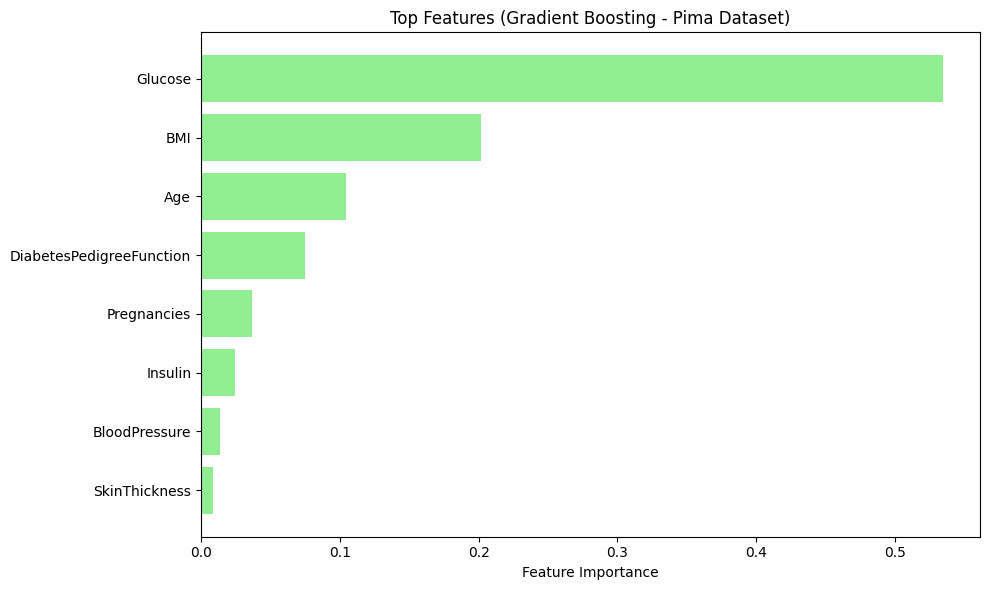

In [12]:
# --- Gradient Boosting with Grid Search - Dataset 2 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# --- 1. Prepare data ---
X = df_pima.drop(columns=['Outcome'])
y = df_pima['Outcome']

# --- 2. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 3. Define base model ---
gb = GradientBoostingClassifier(random_state=42)

# --- 4. Define parameter grid (small + efficient) ---
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 1.0]
}

# --- 5. Grid Search ---
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# --- 6. Evaluate best model ---
best_gb = grid_search.best_estimator_
y_pred = best_gb.predict(X_test)
y_prob = best_gb.predict_proba(X_test)[:, 1]

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV AUC: {grid_search.best_score_:.3f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Test AUC: {roc_auc_score(y_test, y_prob):.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# --- 7. Feature Importance Visualization ---
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_gb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:15][::-1], 
         feature_importances['Importance'][:15][::-1], color='lightgreen')
plt.xlabel('Feature Importance')
plt.title('Top Features (Gradient Boosting - Pima Dataset)')
plt.tight_layout()
plt.show()


I am using F1 and recall for my metrics, below is a chart explaining how all the different metrics can be helpful.

| Metric                   | What It Measures                                    | Best For                                        | Watch Out For                                                          |
| ------------------------ | --------------------------------------------------- | ----------------------------------------------- | ---------------------------------------------------------------------- |
| **Accuracy**             | % of correct predictions overall                    | Balanced datasets                               | Can look great even if the model completely ignores the minority class |
| **Precision**            | % of predicted positives that are actually positive | When *false alarms* are bad                     | Doesn’t care about missed cases                                        |
| **Recall (Sensitivity)** | % of actual positives the model caught              | When missing cases is dangerous (like diabetes) | Can inflate false positives                                            |
| **F1 Score**             | Balance between precision & recall                  | Imbalanced datasets                             | Sensitive to threshold choices                                         |
| **AUC (ROC-AUC)**        | Model’s ability to rank positives above negatives   | Overall model quality                           | Doesn’t directly reflect threshold performance                         |


For further analysis, I can run more iterations of GridSearchCV with more parameter options. First I can do wide ranges, then fine tune around the best range. I can also try using RandomizedSearchCV, or Optuna. I also want to check how tuning changes feature importance. 

Regularization refers to tuning the gradient boost hyperparameters. This allows us to control how the trees are built and combined. Below is a summary table of all the possible hyperparameters to tune. 

Overall I am testing how model performance changes as I increase or decrease regularization.  If training accuracy is greater than testing accuracy, there is too little regularization. If both are low there could be too much regularization (underfitting). Lastly, a highly regularized model spreads importance more evenly across feature while an overfit one gives more importance to only a few variables.

| Parameter                                    | Regularization Role                       | What It Does                                                                                |
| -------------------------------------------- | ----------------------------------------- | ------------------------------------------------------------------------------------------- |
| **`learning_rate`**                          | Shrinks contribution of each tree         | Small values (e.g. 0.05, 0.1) make learning slower and smoother — **strong regularization** |
| **`n_estimators`**                           | Number of boosting stages                 | Too many → overfitting; too few → underfitting                                              |
| **`max_depth`**                              | Limits tree depth                         | Shallower trees prevent overly specific fits — acts like **L2-style regularization**        |
| **`subsample`**                              | Fraction of samples used per tree         | < 1.0 adds randomness (like dropout) — improves generalization                              |
| **`min_samples_split` / `min_samples_leaf`** | Forces minimum data per split or leaf     | Stops trees from chasing noise                                                              |
| **`max_features`**                           | Fraction of features considered per split | Adds stochasticity and reduces overfitting                                                  |
